In [ ]:
!pip install torchdiffeq

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

We define here the useful functions and class for the interpolant method explained in the previous notebook applied t othe 2D case.

In [ ]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
def make_It(path='linear', gamma = None, gamma_dot = None, gg_dot = None):
    """gamma function must be specified if using the trigonometric interpolant"""

    if path == 'linear':

        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'trig':
        if gamma == None:
            raise TypeError("Gamma function must be provided for trigonometric interpolant!")
        a    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)
        b    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        adot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t) \
                                - 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        bdot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t) \
                                + 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'encoding-decoding':

        a    = lambda t: torch.where(t <= 0.5, torch.cos(math.pi*t)**2, torch.tensor(0.))
        adot = lambda t: torch.where(t <= 0.5, -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        b    = lambda t: torch.where(t > 0.5,  torch.cos(math.pi*t)**2, 0.)
        bdot = lambda t: torch.where(t > 0.5,  -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-linear':

        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-trig':

        a      = lambda t: torch.cos(0.5*math.pi*t)
        adot   = lambda t: -0.5*math.pi*torch.sin(0.5*math.pi*t)
        b      = lambda t: torch.sin(0.5*math.pi*t)
        bdot   = lambda t: 0.5*math.pi*torch.cos(0.5*math.pi*t)


        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'mirror':
        if gamma == None:
            raise TypeError("Gamma function must be provided for mirror interpolant!")

        a     = lambda t: gamma(t)
        adot  = lambda t: gamma_dot(t)
        b     = lambda t: torch.tensor(1.0)
        bdot  = lambda t: torch.tensor(0.0)

        It    = lambda t, x0, x1: b(t)*x1 + a(t)*x0
        dtIt  = lambda t, x0, x1: adot(t)*x0

    elif path == 'custom':
        return None, None, None

    else:
        raise NotImplementedError("The interpolant you specified is not implemented.")


    return It, dtIt, (a, adot, b, bdot)


def make_gamma(gamma_type = 'brownian', aval = None):
    """
    returns callable functions for gamma, gamma_dot,
    and gamma(t)*gamma_dot(t) to avoid numerical divide by 0s,
    e.g. if one is using the brownian (default) gamma.
    """
    if gamma_type == 'brownian':
        gamma = lambda t: torch.sqrt(t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(t*(1-t)))) * (1 -2*t)
        gg_dot = lambda t: (1/2)*(1-2*t)

    elif gamma_type == 'a-brownian':
        gamma = lambda t: torch.sqrt(a*t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(a*t*(1-t)))) * a*(1 -2*t)
        gg_dot = lambda t: (a/2)*(1-2*t)

    elif gamma_type == 'zero':
        gamma = gamma_dot = gg_dot = lambda t: torch.zeros_like(t)

    elif gamma_type == 'bsquared':
        gamma = lambda t: t*(1-t)
        gamma_dot = lambda t: 1 -2*t
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sinesquared':
        gamma = lambda t: torch.sin(math.pi * t)**2
        gamma_dot = lambda t: 2*math.pi*torch.sin(math.pi * t)*torch.cos(math.pi*t)
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sigmoid':
        f = torch.tensor(10.0)
        gamma = lambda t: torch.sigmoid(f*(t-(1/2)) + 1) - torch.sigmoid(f*(t-(1/2)) - 1) - torch.sigmoid((-f/2) + 1) + torch.sigmoid((-f/2) - 1)
        gamma_dot = lambda t: (-f)*( 1 - torch.sigmoid(-1 + f*(t - (1/2))) )*torch.sigmoid(-1 + f*(t - (1/2)))  + f*(1 - torch.sigmoid(1 + f*(t - (1/2)))  )*torch.sigmoid(1 + f*(t - (1/2)))
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == None:
        gamma     = lambda t: torch.zeros(1) ### no gamma
        gamma_dot = lambda t: torch.zeros(1) ### no gamma
        gg_dot    = lambda t: torch.zeros(1) ### no gamma

    else:
        raise NotImplementedError("The gamma you specified is not implemented.")


    return gamma, gamma_dot, gg_dot

class Interpolant(torch.nn.Module):
    """
    Class for all things interpoalnt $x_t = I_t(x_0, x_1) + \gamma(t)z.
    If path is one-sided, then interpolant constructs x_t = a(t) x_0 + b(t) x_1 with x_0 ~ N(0,1).

    path: str,    what type of interpolant to use, e.g. 'linear' for linear interpolant. see fabrics for options
    gamma_type:   what type of gamma function to use, e.g. 'brownian' for $\gamma(t) = \sqrt{t(1-t)}
    """
    def __init__(self, path, gamma_type,gamma= None,gamma_dot = None,gg_dot= None,It = None, dtIt= None):
        super(Interpolant, self).__init__()


        self.path = path
        if gamma == None:
            if self.path == 'one-sided-linear' or self.path == 'one-sided-trig':
              gamma_type = None

            self.gamma, self.gamma_dot, self.gg_dot = make_gamma(gamma_type=gamma_type)

        else:
            self.gamma, self.gamma_dot, self.gg_dot = gamma, gamma_dot, gg_dot

        if self.path == 'custom':
            print('Assuming interpolant was passed in directly...')
            self.It = It
            self.dtIt = dtIt
            assert self.It != None
            assert self.dtIt != None


        self.It, self.dtIt, ab = make_It(path, self.gamma, self.gamma_dot, self.gg_dot)
        self.a, self.adot, self.b, self.bdot = ab[0], ab[1], ab[2], ab[3]


    def calc_xt(self, t, x0, x1):
        if self.path =='one-sided-linear' or self.path == 'mirror' or self.path=='one-sided-trig':
            return self.It(t, x0, x1)
        else:
            z = torch.randn(x0.shape).to(t)
            return self.It(t, x0, x1) + self.gamma(t)*z, z


We define the many losses we can have. We need a losses for each functions we want to estimate ( velocity, score, denoiser) and also the path 'one-sided-linear' require a special loss because some simplifications in the formula occur.

In [ ]:
def loss_per_sample_b(b, x0, x1, t, interpolant):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""

    xt, z = interpolant.calc_xt(t, x0, x1)
    xt = xt.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    gamma_dot   = interpolant.gamma_dot(t)
    bt         = b(xt, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt + gamma_dot*z) * bt)
    return loss

def loss_per_sample_b_one_sided(b, x0, x1, t, interpolant):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""

    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    gamma_dot   = interpolant.gamma_dot(t)
    bt         = b(xt, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt) * bt)
    return loss

def loss_per_sample_s(
    s, x0, x1, t, interpolant
):
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""
    xt ,z = interpolant.calc_xt(t, x0, x1)
    xt ,t = xt.unsqueeze(0), t.unsqueeze(0)
    st = s(xt, t)
    loss = 0.5 * torch.sum(st**2) + (1 / interpolant.gamma(t)) * torch.sum(st * z)
    return loss

def loss_per_sample_eta(
    eta, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic sampling."""
    xt, z = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    eta_val = eta(xt, t)
    return 0.5 * torch.sum(eta_val**2) + torch.sum(eta_val * z)


def loss_per_sample_one_sided_s(
    s, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via antithetic samples for x_t = sqrt(1-t)z + sqrt(t) x1 where z=x0."""
    xt, z = interpolant.calc_xt(t, x0, x1)
    xtt = xt.unsqueeze(0), t.unsqueeze(0)
    st = s(xt, t)
    alpha = interpolant.a(t)
    loss = 0.5 * torch.sum(st**2) + (1 / alpha) * torch.sum(st * x0)
    return loss

def loss_per_sample_one_sided_eta(
    eta, x0, x1, t, interpolant
):
    """Compute the loss on an individual sample via samples for x_t = alpha(t)z + beta(t) x1 where z=x0."""
    xt = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    etat = eta(xt, t)
    loss = 0.5 * torch.sum(etat**2) + torch.sum(etat * x0)
    return loss


def make_loss(loss, bvseta, x0,x1, t, interpolant):
    """Convert a sample loss into a batched loss."""
    ## Share the batch dimension i for x0, x1, t
    in_dims_set = (None, 0, 0, 0, None)
    batched_loss = torch.vmap(loss, in_dims=in_dims_set, randomness='different')
    loss_val = batched_loss(bvseta, x0, x1, t, interpolant)
    loss_val = loss_val.mean()
    return loss_val





In [ ]:
# class for SDE sampling.
class SDEIntegrator(torch.nn.Module):
    def __init__(self, b, s = None,eps=torch.tensor(0),interpolant=None,n_save=4,start_end = (0, 1), n_step = 100):
        super(SDEIntegrator, self).__init__()
        self.b =b
        self.s=s
        self.eps = eps
        self.n_save = n_save
        self.n_step = n_step
        self.start_end = start_end
        self.start, self.end = self.start_end
        self.ts = torch.linspace(self.start, self.end, self.n_step)
        self.dt = self.ts[1] - self.ts[0]
        self.interpolant = interpolant
        if self.s is None or self.eps == 0:
            self.bf = self.b
        else:
            self.bf = lambda x, t: self.b(x, t) + self.eps * self.s(x, t)




    def step_forward_heun(self, x: torch.tensor, t: torch.tensor) -> torch.tensor:
        """Heun Step -- see https://arxiv.org/pdf/2206.00364.pdf, Alg. 2"""
        dW = torch.sqrt(self.dt) * torch.randn_like(x)
        xhat = x + torch.sqrt(2 * self.eps) * dW
        K1 = self.bf(xhat, t + self.dt)
        xp = xhat + self.dt * K1
        K2 = self.bf(xp, t + self.dt)
        return xhat + 0.5 * self.dt * (K1 + K2)

    def step_forward(self, x: torch.tensor, t: torch.tensor) -> torch.tensor:
        """Euler-Maruyama."""
        dW = torch.sqrt(self.dt) * torch.randn_like(x)
        return x + self.bf(x, t) * self.dt + torch.sqrt(2 * self.eps) * dW

    def rollout_forward(self, init: torch.tensor, method: str = 'heun') -> torch.tensor:
        """Solve the forward-time SDE to generate a batch of samples."""
        save_every = int(self.n_step / self.n_save)
        xs = torch.zeros((self.n_save, *init.shape)).to(init.device)
        x = init
        self.dt = self.dt.to(init.device)

        save_counter = 0

        for ii, t in enumerate(self.ts[:-1]):
            t = t.to(init.device).unsqueeze(0)
            if method == 'heun':
                x = self.step_forward_heun(x, t)
            else:
                x = self.step_forward(x, t)

            if (ii + 1) % save_every == 0:
                xs[save_counter] = x
                save_counter += 1

        xs[save_counter] = x

        return xs


class SFromEta(torch.nn.Module):
    """Class for turning a noise model into a score model."""
    def __init__(
        self,
        eta,
        gamma,
    ) -> None:
        super(SFromEta, self).__init__()
        self.eta = eta
        self.gamma = gamma

    def forward(self, x, t):
        val = (self.eta(x,t) / self.gamma(t))
        return val

def grab(var):
    return var.detach().cpu().numpy()


# Functions and class for ODE sampling.
def compute_div(f,x,t):
    """Compute the divergence of f(x,t) with respect to x, assuming that x is batched. Assumes data is [bs, d]"""
    bs = x.shape[0]
    with torch.set_grad_enabled(True):
        x.requires_grad_(True)
        t.requires_grad_(True)
        f_val = f(x, t)
        divergence = 0.0
        for i in range(x.shape[1]):
            divergence += \
                    torch.autograd.grad(
                            f_val[:, i].sum(), x, create_graph=True
                        )[0][:, i]

    return divergence.view(bs)


class PFlowRHS(torch.nn.Module):
    def __init__(self, b, interpolant, sample_only=False):
        super(PFlowRHS, self).__init__()
        self.b = b
        self.interpolant = interpolant
        self.sample_only = sample_only


    def setup_rhs(self):
        def rhs(x: torch.tensor, t: torch.tensor):
            self.b.to(x)

            t = t.unsqueeze(0)
            return self.b(x,t)

        self.rhs = rhs


    def forward(self, t, states):
        x = states[0]
        if self.sample_only:
            return (self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (self.rhs(x, t), -compute_div(self.rhs, x, t))

    def reverse(self, t: torch.tensor, states):
        x = states[0]
        if self.sample_only:
            return (-self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (-self.rhs(x, t), compute_div(self.rhs, x, t))

from dataclasses import dataclass
Velocity = torch.nn.Module

@dataclass
class PFlowIntegrator:
    b: Velocity
    method: str
    interpolant: Interpolant
    start_end: tuple = (0.0, 1.0)
    n_step: int = 5
    atol: torch.tensor = 1e-5
    rtol: torch.tensor = 1e-5
    sample_only: bool  = False
    mirror:      bool  = False


    def __post_init__(self) -> None:
        self.rhs = PFlowRHS(b=self.b, interpolant=self.interpolant, sample_only=self.sample_only)
        self.rhs.setup_rhs()

        self.start, self.end = self.start_end[0], self.start_end[1]


    def rollout(self, x0, reverse=False):
        if reverse:
            integration_times = torch.linspace(self.end, self.start, self.n_step).to(x0)
        else:
            integration_times = torch.linspace(self.start, self.end, self.n_step).to(x0)
        dlogp = torch.zeros(x0.shape[0]).to(x0)

        state = odeint(
            self.rhs,
            (x0, dlogp),
            integration_times,
            method=self.method,
            atol=[self.atol, self.atol],
            rtol=[self.rtol, self.rtol]
        )

        x, dlogp = state
        return x, dlogp


def grab(var):
    return var.detach().cpu().numpy()

We now define our model. We choose a Unet with simple time-embedding.

In [63]:
# Model inspired from the Unet in Denoising Diffusion Probabilistic Models : https://arxiv.org/abs/2006.11239 and then simplified by CNRS - Formation FIDLE.
!pip install einops

import torch
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial
import math
from einops import rearrange

def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4),
        channels=3,
        with_time_emb=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ConvNextBlock, mult=convnext_mult)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)


In [36]:
!unzip flowers

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: jpg2/image/image_03190.jpg  
  inflating: jpg2/image/image_03191.jpg  
  inflating: jpg2/image/image_03192.jpg  
  inflating: jpg2/image/image_03193.jpg  
  inflating: jpg2/image/image_03194.jpg  
  inflating: jpg2/image/image_03195.jpg  
  inflating: jpg2/image/image_03196.jpg  
  inflating: jpg2/image/image_03197.jpg  
  inflating: jpg2/image/image_03198.jpg  
  inflating: jpg2/image/image_03199.jpg  
  inflating: jpg2/image/image_03200.jpg  
  inflating: jpg2/image/image_03201.jpg  
  inflating: jpg2/image/image_03202.jpg  
  inflating: jpg2/image/image_03203.jpg  
  inflating: jpg2/image/image_03204.jpg  
  inflating: jpg2/image/image_03205.jpg  
  inflating: jpg2/image/image_03206.jpg  
  inflating: jpg2/image/image_03207.jpg  
  inflating: jpg2/image/image_03208.jpg  
  inflating: jpg2/image/image_03209.jpg  
  inflating: jpg2/image/image_03210.jpg  
  inflating: jpg2/image/image_03211.jpg 

We now import the CIFAR dataset and normalize the data.

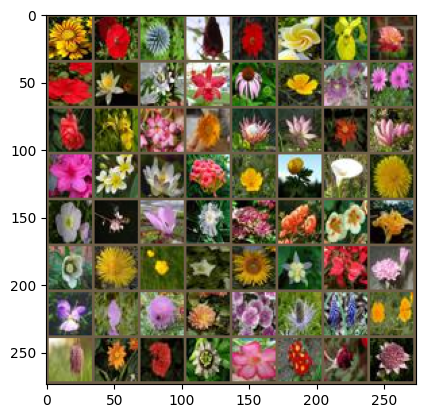

In [64]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

directory = '/content/jpg2'

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43531922, 0.37799895, 0.29074696], std=[0.24403198, 0.19294092, 0.19901074])
])

dataset = torchvision.datasets.ImageFolder(root=directory, transform=transform)

batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

mean = [0.43531922, 0.37799895, 0.29074696]
std = [0.24403198, 0.19294092, 0.19901074]

def denormalize(img):
    img = img.numpy()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    return img

def imshow(img):
    img = denormalize(img)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

data_iter = iter(train_loader)
images, _ = next(data_iter)

imshow(torchvision.utils.make_grid(images))


We can now train our model by training both eta and the velocity b.

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




base_lr = 1e-4
bs = 64

path = 'one-sided-linear'
interpolant  = Interpolant(path=path, gamma_type='')

b = Unet(dim=32).to(device)
eta = Unet(dim=32).to(device)
opt_b     = torch.optim.Adam(  b.parameters(), lr=base_lr)
opt_eta   = torch.optim.Adam(eta.parameters(), lr=base_lr)
#sched_b   = torch.optim.lr_scheduler.StepLR(optimizer=  opt_b, step_size=1500, gamma=0.2)
#sched_eta = torch.optim.lr_scheduler.StepLR(optimizer=opt_eta, step_size=1500, gamma=0.2)

import torch

opt_b = torch.optim.Adam(b.parameters(), lr=1e-4)
opt_eta = torch.optim.Adam(eta.parameters(), lr=1e-4)
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = len(train_loader)
for epoch in range(epochs):
    b.train()
    eta.train()
    epoch_loss = 0
    for x1, label in train_loader:
        x1 = x1.to(device)
        x0 = torch.randn_like(x1).to(device)

        ts = torch.rand(size=(x1.shape[0],)).to(device)

        loss_b = make_loss(loss_per_sample_b_one_sided, b, x0, x1, ts, interpolant)
        loss_eta = make_loss(loss_per_sample_one_sided_eta, eta, x0, x1, ts, interpolant)
        loss = loss_b + loss_eta
        epoch_loss += loss.item()/n
        opt_b.zero_grad()
        opt_eta.zero_grad()
        loss_b.backward()
        loss_eta.backward()
        opt_b.step()
        opt_eta.step()
        #sched_b.step()
        #sched_eta.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')






Epoch 1/30, Loss: -1132.7101039290428
Epoch 2/30, Loss: -1957.141975402832
Epoch 3/30, Loss: -2357.8192138671875
Epoch 4/30, Loss: -2583.719169616699
Epoch 5/30, Loss: -2775.119882583618
Epoch 6/30, Loss: -2937.141164779663
Epoch 7/30, Loss: -3082.899627685547
Epoch 8/30, Loss: -3190.838354110718
Epoch 9/30, Loss: -3291.9371585845947
Epoch 10/30, Loss: -3350.3128204345703
Epoch 11/30, Loss: -3402.215476989746
Epoch 12/30, Loss: -3458.0875415802
Epoch 13/30, Loss: -3479.3929233551025
Epoch 14/30, Loss: -3529.4883918762207
Epoch 15/30, Loss: -3556.363681793213
Epoch 16/30, Loss: -3569.66379737854
Epoch 17/30, Loss: -3581.805913925171
Epoch 18/30, Loss: -3612.328332901001
Epoch 19/30, Loss: -3625.171085357666
Epoch 20/30, Loss: -3645.4855365753174
Epoch 21/30, Loss: -3663.6769409179688
Epoch 22/30, Loss: -3685.3155307769775
Epoch 23/30, Loss: -3711.527509689331
Epoch 24/30, Loss: -3709.882709503174
Epoch 25/30, Loss: -3730.6946849823
Epoch 26/30, Loss: -3743.019479751587
Epoch 27/30, Loss

We now can visualize our results using our models trained to estimate the velocity and the score and use the forward Fokker-Plank equation (SDE) to generate new samples.

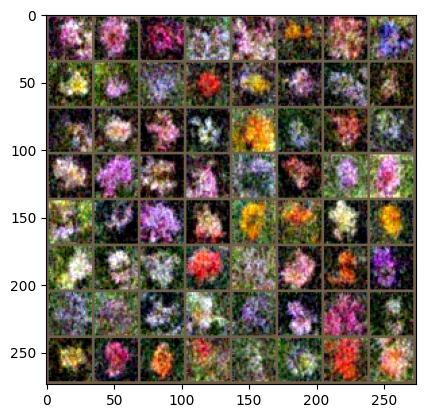

<Figure size 640x480 with 0 Axes>

In [72]:
s = SFromEta(eta, interpolant.a)

sde_flow = SDEIntegrator(b=b, s=s, eps=torch.tensor(0.01), n_save=4, start_end=(0.0001, 0.999), n_step=10**3).to(device)
# pflow = PFlowIntegrator(b=b,  method='dopri5', interpolant=interpolant, n_step=3) ODE
bs = 64
with torch.no_grad():
    x0_tests  = torch.randn(bs,3, 32, 32).to(device)
    xfs_sde   = sde_flow.rollout_forward(x0_tests, 'heun')
    xf_sde    = grab(xfs_sde[-1].squeeze())
    xf_sde = xf_sde.reshape(64,3,32,32)
    imshow(torchvision.utils.make_grid(torch.tensor(xf_sde)))
    xf_sde = xf_sde.transpose(0, 2, 3, 1)


plt.tight_layout()
plt.show()